<h1>Student Performance Predictor</h1>
This is an analysis of the <a href = 'https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data'>Predict Students' Dropout and Academic Success</a> dataset, which I sourced from Kaggle. This dataset contains academic, demographic, and socioeconomic data about Portuguese university students. In this analysis, I intend to determine factors affecting students' academic outcomes (dropout/graduate). I will use Pandas to load and manipulate the data, and seaborn to create visualizations. Lastly, I will train machine learning models on this feature set to predict student outcomes. I will apply this model to predict the outcome for all students currently enrolled to determine the most in need. 

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load the dataset
students = pd.read_csv('data/dataset.csv')

#Rename Nacionality column to English spelling
students.rename(columns = {'Nacionality': 'Nationality'}, inplace = True)

#Display the first rows of the dataset
students.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


A student can have a Target value of 'Dropout' if they dropped out of college, 'Graduate' if they completed college, or 'Enrolled' if they are still in college. When training the machine learning models, I am concerned only with whether or not a student completed college. I'll put the data on enrolled students off to the side for now. After I train the model, I'll input the enrolled student data to determine which students are most in need of support. 

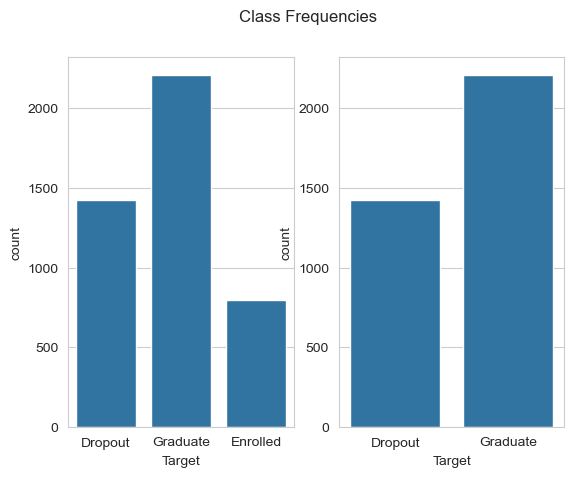

In [3]:
#Sets the seaborn figure style for all plots
sns.set_style("whitegrid")

#Use matplotlib to create 2 subplots (1 row, 2 cols)
fig, axes = plt.subplots(1, 2)
#Add a title to the whole plot
fig.suptitle('Class Frequencies')

#Create a countplot of target class frequencies (including Enrolled students)
sns.countplot(data = students, ax = axes[0], x = 'Target')

#Isolate data about Enrolled students, then remove that data from the students Data Frame
students_enrolled = students[students['Target'] == 'Enrolled']
students = students[students['Target'].isin(['Graduate', 'Dropout'])]

#Create a countplot of target class frequencies (excluding Enrolled students)
sns.countplot(data = students, ax = axes[1], x = 'Target')
plt.show()

I'll use Pandas' info() function to examine the datatypes and determine if any rows are missing values. It looks like there aren't any Null values, but I notice categorical rows like Marital Status and Nationality are stored as integers. I'll fix that in the next code block. 

In [4]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  3630 non-null   int64  
 1   Application mode                                3630 non-null   int64  
 2   Application order                               3630 non-null   int64  
 3   Course                                          3630 non-null   int64  
 4   Daytime/evening attendance                      3630 non-null   int64  
 5   Previous qualification                          3630 non-null   int64  
 6   Nationality                                     3630 non-null   int64  
 7   Mother's qualification                          3630 non-null   int64  
 8   Father's qualification                          3630 non-null   int64  
 9   Mother's occupation                           

Many of these columns contain categorical data, which are stored in this dataset as factors. A dataframe containing only numeric data is perfect for training machine learning algorithms, but it isn't easy to extract meaning when a student's Marital status is 2 and their nationality is 1. Luckily, the dataset comes with CSV files for each categorical column that matches numbers with their values. I'll make a copy of the dataframe for training the models. After, I'll load the CSVs and replace the numeric representations with the true values for each category. 

In [5]:
#Copy dataframe containing factor data for training ML models
students_factor = students.copy()

#The csv list stores the name of the CSV files containing the true category values
csv = ['marital_status', 'application_mode', 'course_names', 'previous_quals', 'nationality', 'parent_previous_quals', 'parent_occupation']
#The col list stores the names of the columns in the students dataframe that correspond to each CSV file
col = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 'Nationality', "Mother's qualification", "Mother's occupation"]

#Loop iterates through each categorical column
for i in range(len(csv)):
    #Reads the CSV as a dataframe, then converts to a dictionary
    replace_dict = pd.read_csv('data/' + csv[i] + '.csv', index_col = 'ID').to_dict()
    #Pandas reads the CSV file into a dictionary of dictionaries
    #The value dictionary is the first and only dictionary, so I use the .keys() function to extract this dictionary
    replace_dict = replace_dict[list(replace_dict.keys())[0]]

    #Uses the loaded dictionary to replace the factor values with the true values
    students[col[i]] = students[col[i]].replace(replace_dict).astype('category')

    #The parent_previous_quals and parent_occupation contain replacement values for Mother and Father column
    #This if-statement ensures the Father column values are properly replaced
    if "Mother's" in col[i]:
        father_col = col[i].replace('Mother', 'Father')
        students[father_col] = students[father_col].replace(replace_dict).astype('category')

#Daytime/evening attendnace and Gender contain only 2 values, so I replace their factor values without loading a CSV file
students['Daytime/evening attendance'] = students['Daytime/evening attendance'].replace({0: 'Evening', 1: 'Daytime'}).astype('category')
students['Gender'] = students['Gender'].replace({0: 'Female', 1: 'Male'}).astype('category')

#Displays the corrected categorical columns and the Target column
students[col + ['Daytime/evening attendance', 'Gender', 'Target']].head()

,Marital status,Application mode,Course,Previous qualification,Nationality,Mother's qualification,Mother's occupation,Daytime/evening attendance,Gender,Target
0,Single,2nd phase—general contingent,Animation and Multimedia Design,Secondary education,Portuguese,General commerce course,"Personal Services, Security and Safety Workers...",Daytime,Male,Dropout
1,Single,International student (bachelor),Tourism,Secondary education,Portuguese,Secondary Education—12th Year of Schooling or ...,Intermediate Level Technicians and Professions,Daytime,Male,Graduate
2,Single,1st phase—general contingent,Communication Design,Secondary education,Portuguese,General Course of Administration and Commerce,Unskilled Workers,Daytime,Male,Dropout
3,Single,2nd phase—general contingent,Journalism and Communication,Secondary education,Portuguese,Supplementary Accounting and Administration,"Personal Services, Security and Safety Workers...",Daytime,Female,Graduate
4,Married,Over 23 years old,Social Service (evening attendance),Secondary education,Portuguese,General Course of Administration and Commerce,Unskilled Workers,Evening,Female,Graduate


Much better.

Now that the data is properly labeled, I'll calculate correlation to determine what features indicate a student's outcome. I'll rate the correlations by positive/negative and by their strength. These columns are more likely to have higher weights in the machine learning models. 

In [6]:
#Converts the Target column to a numerical factor for correlation calculations
students_factor['Target'] = pd.factorize(students_factor['Target'])[0]

#Calculates the correlation between all columns in the students dataframe
#I select only the 'Target' column to measure correlation with the target attribute
outcome_corr = pd.DataFrame(students_factor.corr()['Target']).reset_index(names = 'Column')
#Assigns a level to each correlation value
    #Strong positive: > 0.5
    #Moderate positive: > 0.3
    #Weak positive: >0.1
    #No correlation: < 0.1 and > -0.1
    #Weak correlation: < -0.1
#There are no features with a moderate negative or strong negative correlation with the target
outcome_corr['Level'] = np.where(outcome_corr['Target'] > 0.5, 'Strong Positive', 
                              np.where(outcome_corr['Target'] > 0.3, 'Moderate Positive', 
                              np.where(outcome_corr['Target'] > 0.1, 'Weak Positive', 
                              np.where(outcome_corr['Target'] < -0.1, 'Weak Negative', 
                              'No Correlation'))))

#Selects all columns correlated with the Target column that are not the target column
outcome_corr = outcome_corr[(outcome_corr['Level'] != 'No Correlation') & (outcome_corr['Target'] != 1)]
#Displays the correlated values, sorted by the amount of correlation
outcome_corr.sort_values(by = 'Target', ascending = False)

,Column,Target,Level
28,Curricular units 2nd sem (approved),0.653995,Strong Positive
29,Curricular units 2nd sem (grade),0.605350,Strong Positive
22,Curricular units 1st sem (approved),0.554881,Strong Positive
23,Curricular units 1st sem (grade),0.519927,Strong Positive
14,Tuition fees up to date,0.442138,Moderate Positive
16,Scholarship holder,0.313018,Moderate Positive
26,Curricular units 2nd sem (enrolled),0.182897,Weak Positive
20,Curricular units 1st sem (enrolled),0.161074,Weak Positive
11,Displaced,0.126113,Weak Positive
27,Curricular units 2nd sem (evaluations),0.119239,Weak Positive


The four variables strongly correlated are all related to student grades. This intuitively makes sense - students who earn higher grades are more likely to graduate. There is moderate positive correlation for 'Tuition Fees Up-To-Date' and 'Scholarship Holders'. Students who can pay for college are also more likely to graduate. The weakly-correlated features include demographic data, like a student's marital status and gender. I'll investigate some of these features through Seaborn visualizations.

I find it interesting (and uplifting) that a student's Special Needs status is not correlated with their outcome. I'll examine this variable first to determine if that's true. 

Educational special needs
0    0.391086
1    0.425000
Name: count, dtype: float64


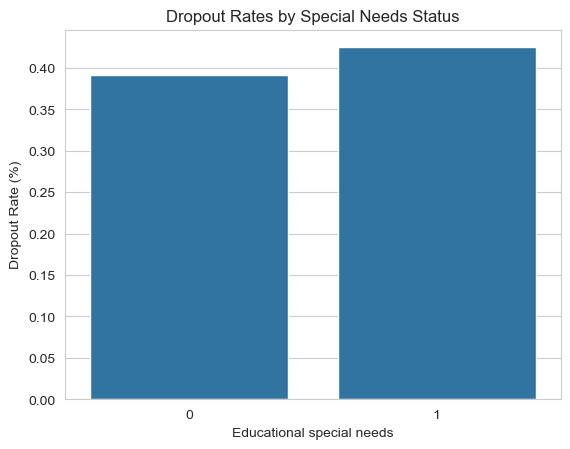

In [7]:
#Counts frequencies of students with/without special needs who dropped out
dropout = students[students['Target'] == 'Dropout']['Educational special needs'].value_counts()
#Counts frequencies of students with special needs
disability_dropout_ratio = dropout / students['Educational special needs'].value_counts()

print(disability_dropout_ratio)

#Plots the dropout rates of students with/without special needs
sns.barplot(disability_dropout_ratio)
plt.title('Dropout Rates by Special Needs Status')
plt.ylabel('Dropout Rate (%)')
plt.show()

The dropout rate for students with educational special needs is slightly higher. I'll use hypothesis testing to determine if this is statistically significant. It should be noted that there are many more students in the dataset without educational special needs, so the results of the hypothesis test should be taken with a grain of salt. 

In [8]:
#Setting the significance level, alpha, to the standard value of 0.05
alpha = 0.05

#Proportions of students who dropped out, grouped by their special needs status
p_hats = students.groupby('Educational special needs')['Target'].value_counts(normalize = True)
#Counts of students by their special needs status
n = students.groupby('Educational special needs')['Target'].count()

#Proportion of students without special needs who dropped out
p_hat_nsn = p_hats.iloc[1]
#Number of students without special needs
n_nsn = n[0]

#Proportion of students with educational special needs who dropped out
p_hat_esn = p_hats.iloc[3]
#Number of students with special needs
n_esn = n[1]

p_hat = (n_nsn * p_hat_nsn + n_esn * p_hat_esn) / (n_nsn + n_esn)

#Standard error calculation
std_error = np.sqrt(p_hat * (1 - p_hat) / n_nsn + p_hat * (1 - p_hat) / n_esn)

#z-score calculation for two-tailed proportion test
z_score = (p_hat_esn - p_hat_nsn) / std_error

#Calculate the p_val using scipy and the z-score
p_val = scipy.stats.norm.sf(abs(z_score)) * 2

#Output the p_value
print('p-value:', p_val)

p-value: 0.6620903893799748


The p-value is much greater than the significance level of 0.05, so I can confidently say the difference in dropout rates for special needs students is not statistically significant. 

Next, I'll visualize the features correlated with the target variable. 

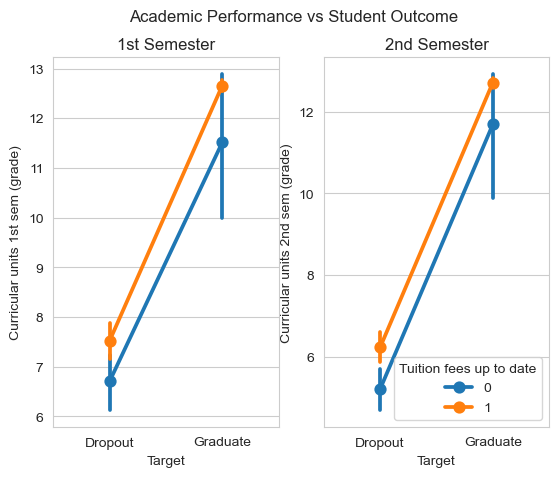

In [9]:
#Use matplotlib to create 2 subplots (1 row, 2 cols)
fig, axes = plt.subplots(1, 2)
#Add a title to the whole plot
fig.suptitle('Academic Performance vs Student Outcome')

sns.pointplot(data = students, ax = axes[0], x = 'Target', y = 'Curricular units 1st sem (grade)', hue = 'Tuition fees up to date', legend = False)
sns.pointplot(data = students, ax = axes[1], x = 'Target', y = 'Curricular units 2nd sem (grade)', hue = 'Tuition fees up to date', legend = True)

axes[0].set_title('1st Semester')
axes[1].set_title('2nd Semester')

sns.move_legend(axes[1], 'lower right')

plt.show()

This dataset tracks Portuguese university students. In <a href = 'https://www.ipportalegre.pt/media/filer_public/06/68/06684969-eeb7-467a-ab6e-053db7fe41a2/fact_sheet.pdf'>Portugal's grading system</a>, a grade less than 10 is a fail (F). Students who dropped out performed poorly in their first and second semesters. Moreover, the academic performance of students who are behind on their tuition fees is worse than those who are up to date. This indicates that, on average, students with more money perform better than less well-off students. 

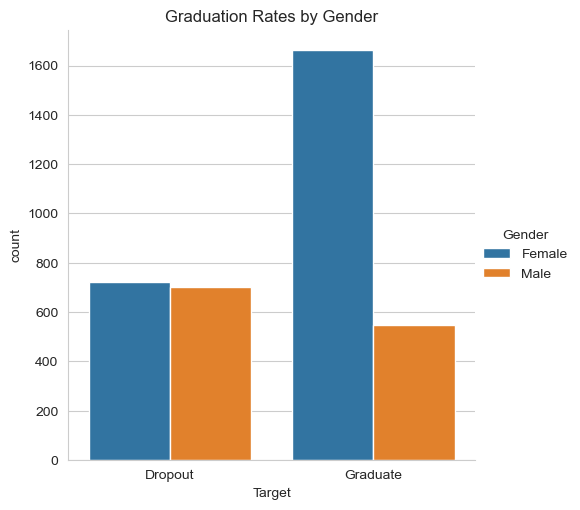

In [10]:
sns.catplot(data = students, kind = 'count', x = 'Target', hue = 'Gender')
plt.title("Graduation Rates by Gender")
plt.show()

A similar number of male and female students dropped out, but many more female students graduated. The model will be more likely to predict that a female student will graduate than a male student. 

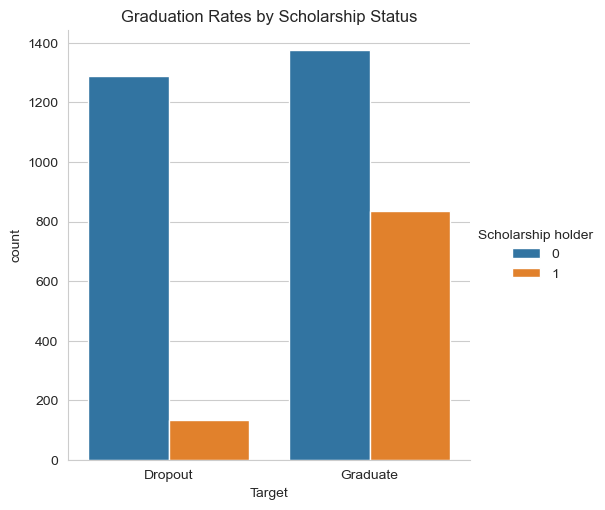

In [11]:
sns.catplot(data = students, kind = 'count', x = 'Target', hue = 'Scholarship holder')
plt.title("Graduation Rates by Scholarship Status")
plt.show()

The counts of students without scholarships who dropped out vs those who graduated are very similar. However, among students who received scholarships, the majority graduated. This makes sense. Scholarships are often tied to academic performance, and students who earn higher grades are more likely to graduate. 

Next, I'll use the feature set and a variety of machine learning models to predict student outcomes. I'll use the scikit-learn library to do this. First, I'll set a random seed of 20 so the results are easily reproducible. I'll separate the feature columns from the target, and use train_test_split to create a training set and a testing set. I'll use 10% of the data for testing

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

np.random.seed(20)

features = students_factor.iloc[:,:-1]
target = students_factor['Target']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.1)

I'll start with a decision tree classifier, a model known for being easy to understand. I'll use information gain and entropy as the criteria for what nodes are created, and train it with the training set. I'm using 10-fold cross-validation to measure the accuracy of my models. This returns 10 accuracies. I'll measure the accuracy of each model as the average of its cross-validation accuracies. I'll also report the maximum accuracy for each model. 

In [13]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(criterion = 'entropy').fit(x_train, y_train)

acc = cross_val_score(tree_model, x_test, y_test, cv = 10)
print(np.mean(acc))
print(np.max(acc))

0.8543543543543544
0.8888888888888888


The decision tree classifier performs well on this dataset. I planned on graphing the decision tree, but there are 34 features in this dataset, so the visual is not easy to read. I'll test the random forest classifier next, an ensemble method that combines multiple decision trees and classifies based on their "votes". 

In [14]:
from sklearn.ensemble import RandomForestClassifier

ensemble_model = RandomForestClassifier().fit(x_train, y_train)

acc = cross_val_score(ensemble_model, x_test, y_test, cv = 10)
print(np.mean(acc))
print(np.max(acc))

data = {
    'Column': ensemble_model.feature_names_in_,
    'Weight': ensemble_model.feature_importances_
}

print(pd.DataFrame(data).sort_values(by = 'Weight', ascending = False).iloc[:10])

0.9093093093093092
0.972972972972973
                                    Column    Weight
28     Curricular units 2nd sem (approved)  0.203898
22     Curricular units 1st sem (approved)  0.155214
23        Curricular units 1st sem (grade)  0.085109
29        Curricular units 2nd sem (grade)  0.083984
14                 Tuition fees up to date  0.062815
17                       Age at enrollment  0.039045
27  Curricular units 2nd sem (evaluations)  0.036834
21  Curricular units 1st sem (evaluations)  0.029591
3                                   Course  0.029454
16                      Scholarship holder  0.021022


The random forest classifier performs much better than a single decision tree. As a bonus, I can display the features that the classifier finds most important. These mostly match the features that are highly correlated with the target classm, like 1st and 2nd semester grades.

In [15]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB().fit(x_train, y_train)

acc = cross_val_score(nb_model, x_test, y_test, cv = 10)
print(np.mean(acc))
print(np.max(acc))

0.8484234234234235
0.9444444444444444


The Naive Bayes classifier performs similarly to the decision tree classifier. NB algorithms assume that all of the features are independent of one another. However, I've seen that a student's academic performance is affected by their tuition payment status, so dependencies exist among the features. That being said, the Naive Bayes classifier performs well on this dataset. 

In [16]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression(solver = 'liblinear').fit(x_train, y_train)

acc = cross_val_score(linear_model, x_test, y_test, cv = 10)
print(np.mean(acc))
print(np.max(acc))

0.9036786786786786
1.0


The logistic regression model performs the best out of all non-ensemble models so far. I worry the classifier is overfitting, as one of the cross-validation models was 100% accurate. 

In [17]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC().fit(x_train, y_train)

acc = cross_val_score(svm_model, x_test, y_test, cv = 10)
print(np.mean(acc))
print(np.max(acc))

0.8953453453453454
0.972972972972973


The support vector machine model also performs well on this dataset, though not as well as logistic regression. However, SVMs perform well on high-dimensional data and are less-prone to overfitting, so I may choose this as the final model. 

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 5).fit(x_train, y_train)

acc = cross_val_score(knn_model, x_test, y_test, cv = 10)
print(np.mean(acc))
print(np.max(acc))

0.8014264264264265
0.8918918918918919


K Nearest Neighbors struggles with this dataset compared to the other models. I found that the accuracy did not improve much when increasing the number of neighbors beyond 5. 

Next, I'll predict the final outcome of the students who are currently enrolled. This will identify students at a greater risk of dropping out, and could improve graduation rates over time. As I don't know the final outcome of these students, I am unable to measure the outcome of this prediction. 

In [19]:
#Predicts student outcomes with SVM model. 0 = dropout, 1 = graduate
students_enrolled['Prediction'] = svm_model.predict(students_enrolled.iloc[:, 0:34])

print(sum(students_enrolled['Prediction']) / len(students_enrolled)) 

#Displays dataframe of students predicted to drop out
students_enrolled[students_enrolled['Prediction'] == 0]

0.575566750629723


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Prediction
16,1,9,1,10,1,1,1,13,28,6,...,6,14,2,11.000000,0,10.8,1.4,1.74,Enrolled,0
32,1,1,1,9,1,1,1,1,1,5,...,5,8,2,13.500000,0,8.9,1.4,3.51,Enrolled,0
45,1,8,1,17,0,1,1,23,28,5,...,5,11,3,14.333333,1,7.6,2.6,0.32,Enrolled,0
52,1,1,1,15,1,1,1,1,14,8,...,6,12,3,11.000000,0,9.4,-0.8,-3.12,Enrolled,0
63,1,8,1,5,1,1,1,1,1,4,...,6,8,1,10.000000,0,10.8,1.4,1.74,Enrolled,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,1,1,2,10,1,1,1,1,14,5,...,5,11,0,0.000000,0,9.4,-0.8,-3.12,Enrolled,0
4397,1,3,4,16,1,1,1,3,28,4,...,6,9,3,11.666667,0,9.4,-0.8,-3.12,Enrolled,0
4406,1,1,1,5,1,1,1,1,28,6,...,6,8,2,11.333333,0,10.8,1.4,1.74,Enrolled,0
4412,1,14,1,5,1,1,1,13,14,8,...,6,7,5,12.200000,0,13.9,-0.3,0.79,Enrolled,0
